In [164]:
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import cdist

In [165]:
#Load the dataset
df = pd.read_csv('AvalancheData2.csv')

#Setups labels for three avalanche prediction regions
Y1 = df['Day1DangerAboveTreeline'].replace('Extreme', 'High')
Y2 = df['Day1DangerNearTreeline'].replace('Extreme', 'High')
Y3 = df['Day1DangerBelowTreeline'].replace('Extreme', 'High')

# Remove columns without useful data for training
X = df.drop(['ID','ForecastUrl','Date','ConvertedDate','Sep1_Year','Sep1_Prior_Year','Day1DangerAboveTreeline','Day1DangerNearTreeline','Day1DangerBelowTreeline'], axis=1)

In [166]:
# Explore the data

print("=" * 60)
print("DATASET HEAD")
print("=" * 60)
print(X.head())
print("\n")

print("=" * 60)
print("DATASET INFO")
print("=" * 60)
print(X.info())
print("\n")

print("=" * 60)
print("MISSING VALUES")
print("=" * 60)
missing = X.isnull().sum()
missing_pct = (X.isnull().sum() / len(X)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])
print("\n")

DATASET HEAD
   Days_Since_Sep1                       Region Cornices_Likelihood  \
0              101                     Olympics                 NaN   
1              101  Cascade Pass - Stevens Pass                 NaN   
2              101    Cascade Pass - Snoq. Pass                 NaN   
3              101                      Mt Hood                 NaN   
4              101         Cascade West - North                 NaN   

  Cornices_MaximumSize Cornices_MinimumSize DeepPersistentSlabs_Likelihood  \
0                  NaN                  NaN                            NaN   
1                  NaN                  NaN                            NaN   
2                  NaN                  NaN                            NaN   
3                  NaN                  NaN                            NaN   
4                  NaN                  NaN                            NaN   

  DeepPersistentSlabs_MaximumSize DeepPersistentSlabs_MinimumSize  \
0                     

In [167]:
numerical_features = X.select_dtypes(include=['int64', 'float64'])
numerical_features = numerical_features.columns.tolist()
categorical_features = X.select_dtypes(include=['object'])
categorical_features_nominal = ['Region']
categorical_features_ordinal = [ 'Cornices_Likelihood',
 'Cornices_MaximumSize',
 'Cornices_MinimumSize',
 'DeepPersistentSlabs_Likelihood',
 'DeepPersistentSlabs_MaximumSize',
 'DeepPersistentSlabs_MinimumSize',
 'LooseWet_Likelihood',
 'LooseWet_MaximumSize',
 'LooseWet_MinimumSize',
 'PersistentSlabs_Likelihood',
 'PersistentSlabs_MaximumSize',
 'PersistentSlabs_MinimumSize',
 'StormSlabs_Likelihood',
 'StormSlabs_MaximumSize',
 'StormSlabs_MinimumSize',
 'WindSlabs_Likelihood',
 'WindSlabs_MaximumSize',
 'WindSlabs_MinimumSize']

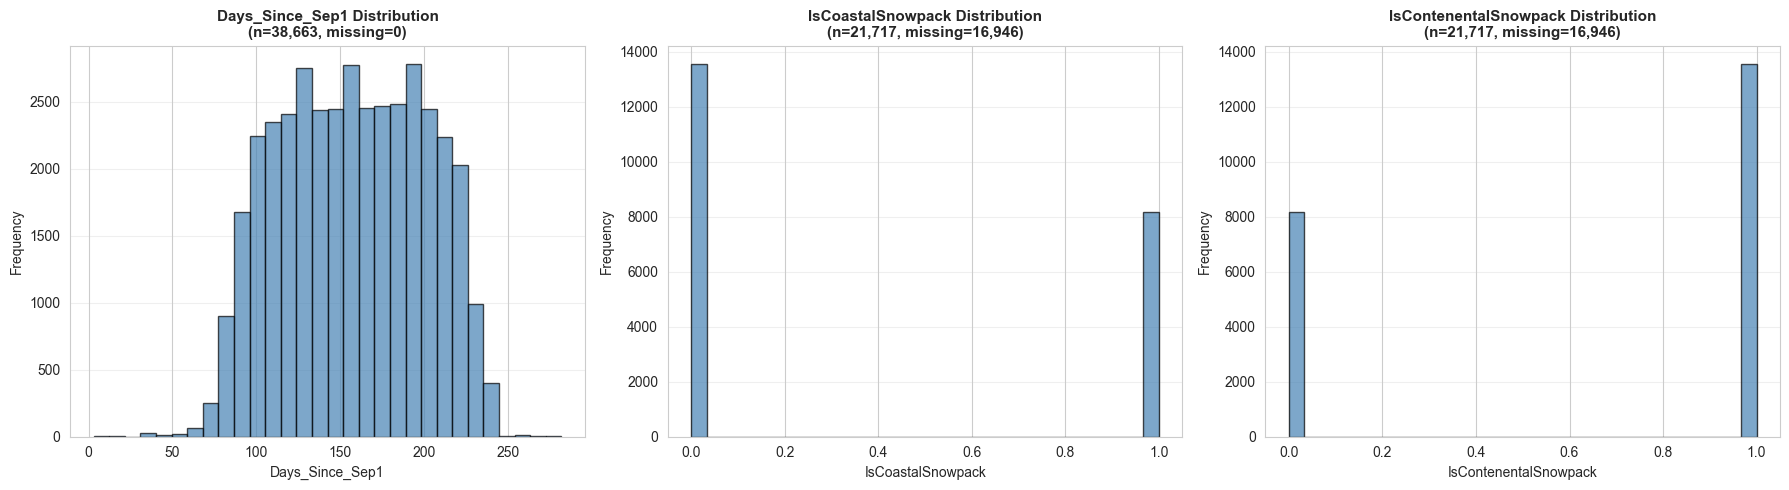

In [168]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ============================================================================
# NUMERICAL VARIABLES - HISTOGRAMS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
for idx, col in enumerate(numerical_features):
    ax = axes[idx]
    data = X[col].dropna()
        
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{col} Distribution\n(n={len(data):,}, missing={df[col].isnull().sum():,})', 
                     fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
plt.tight_layout()
plt.show()

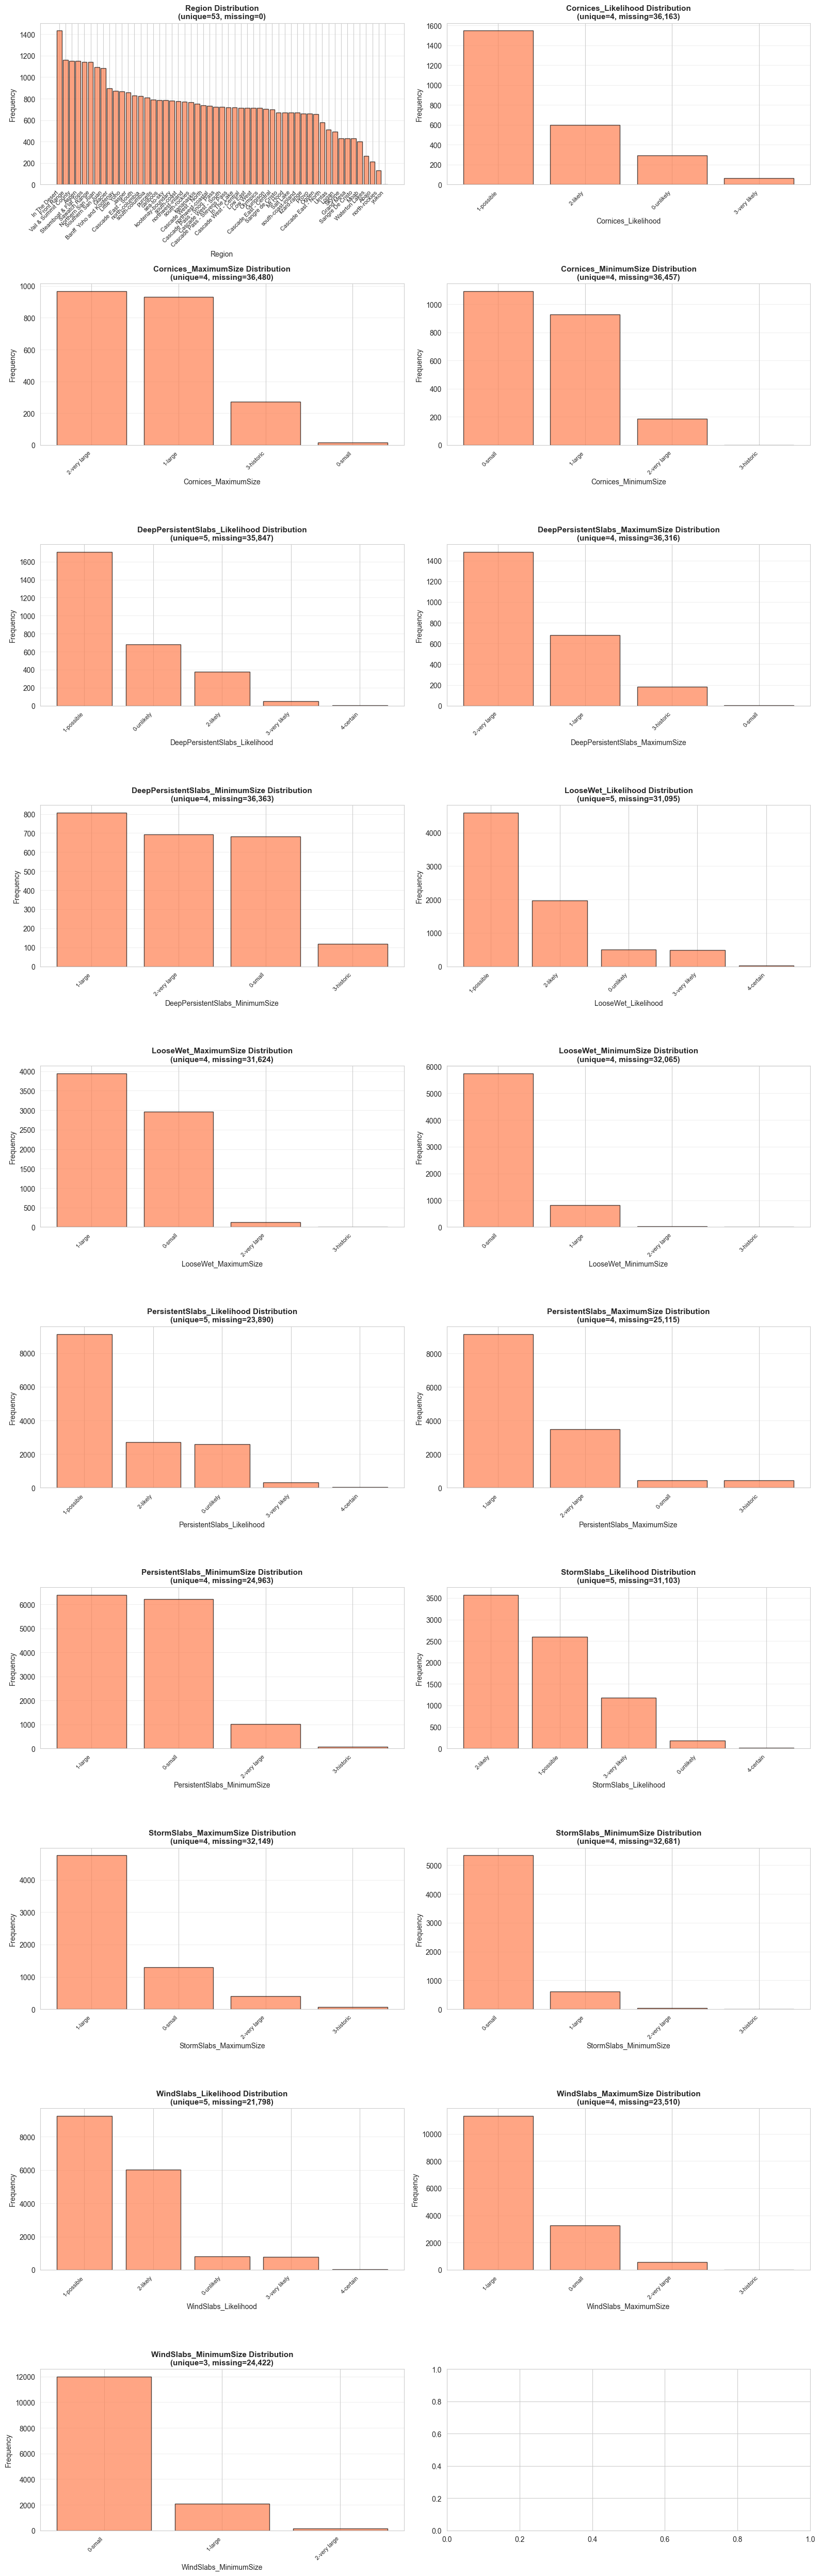

In [169]:
# ============================================================================
# CATEGORICAL VARIABLES - BAR CHARTS
# ============================================================================

categorical_cols = categorical_features.columns.tolist()
n_cat_cols = len(categorical_cols)
n_rows = int(np.ceil(n_cat_cols / 2))
    
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5*n_rows))
axes = axes.flatten()  # Flatten 2D axes array to 1D for easier indexing
    
for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
        
    # Get value counts
    value_counts = X[col].value_counts()
    n_unique = X[col].nunique()
    n_missing = X[col].isnull().sum()
        
    # Create bar plot
    bars = ax.bar(range(len(value_counts)), value_counts.values, 
                      edgecolor='black', alpha=0.7, color='coral')
        
    # Set x-axis labels
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
        
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
        
    title = f'{col} Distribution\n(unique={n_unique}, missing={n_missing:,})'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
plt.tight_layout()
plt.show()

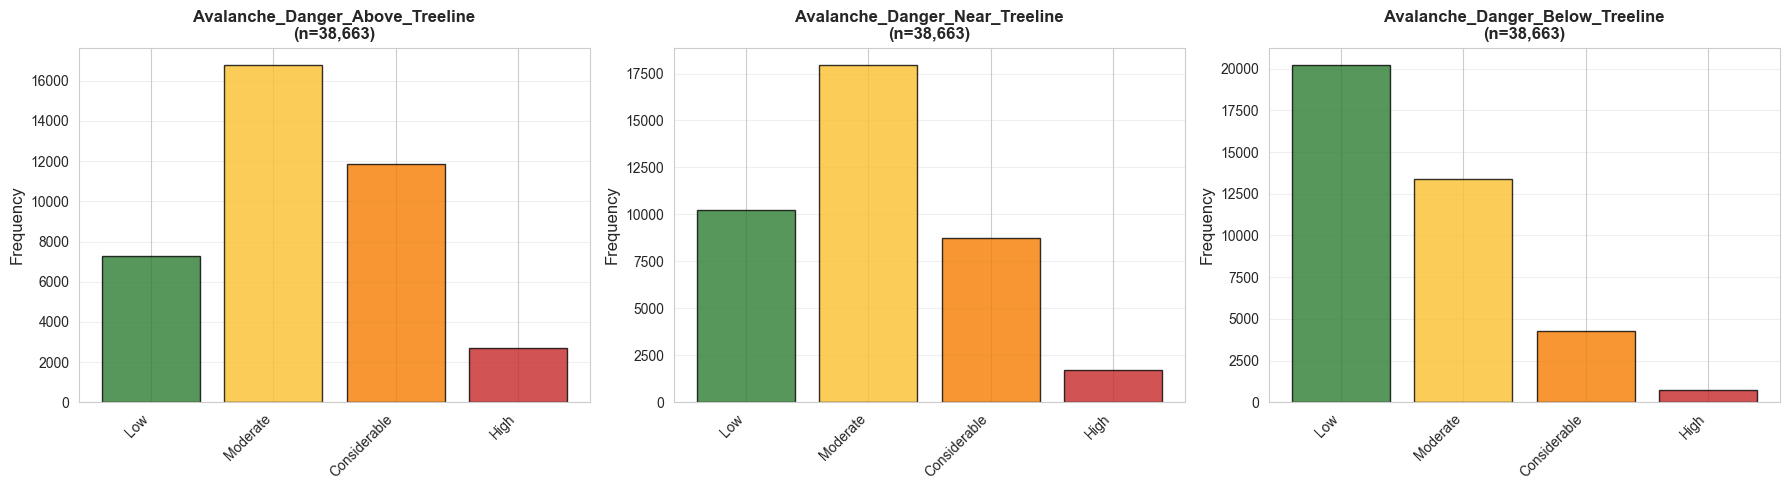

In [170]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

_order = ['Low', 'Moderate', 'Considerable', 'High']

for idx, (y_name, y_target) in enumerate([('Avalanche_Danger_Above_Treeline', Y1), ('Avalanche_Danger_Near_Treeline', Y2), ('Avalanche_Danger_Below_Treeline', Y3)]):
    ax = axes[idx]
    
    # get counts and ensure consistent ordering for the categories
    value_counts = y_target.value_counts().reindex(_order, fill_value=0)
    
    # Define color mapping for danger levels
    danger_colors = {
        'Low': '#2E7D32',
        'Moderate': '#FBC02D', 
        'Considerable': '#F57C00',
        'High': '#C62828',
    }
    
    colors = [danger_colors.get(val, 'gray') for val in value_counts.index]
    
    # plot using category labels directly
    bars = ax.bar(value_counts.index, value_counts.values, 
                  color=colors, edgecolor='black', alpha=0.8)
    
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'{y_name}\n(n={y_target.notna().sum():,})', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [171]:
numerical_transformer = Pipeline([('num_imputer', SimpleImputer(strategy='median')),
                                  ('num_scaler', StandardScaler())])

categorical_transformer_nominal = Pipeline([('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_ordinal = Pipeline([('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat_nominal', categorical_transformer_nominal, categorical_features_nominal),
    ('cat_ordinal', categorical_transformer_ordinal, categorical_features_ordinal)
])

In [172]:
# Update models with class_weight where supported
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),  # No class_weight support
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42),
    'Neural Network': MLPClassifier(random_state=42)  # No class_weight support
}

# Train only on Y1
print(f"\n{'#'*60}")
print(f"### Training models for Y1 (Above Treeline) ###")
print('#'*60)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2, random_state=42)

# Compute sample weights for models that need them
sample_weights = compute_sample_weight('balanced', y_train)

# Loop through models
results = {}
for name, modelType in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)

    # Create pipeline
    model = Pipeline([('preprocessor', preprocessor),
                    ('model', modelType)])

    # Fit with or without sample weights
    if name in ['Gradient Boosting', 'Neural Network']:
        # These don't support class_weight, use sample_weight
        model.fit(X_train, y_train, model__sample_weight=sample_weights)
    else:
        # These have class_weight='balanced' already
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # Evaluate with BOTH accuracy and balanced accuracy
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {
        'accuracy': accuracy,
        'f1 score': f1_macro
    }

    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 score: {f1_macro:.3f}")
    print(classification_report(y_test, y_pred, zero_division=0))

# Summary
print(f"\n{'='*50}")
print(f"Summary of Results for Y1")
print('='*50)
print(f"{'Model':<25} {'Accuracy':<12} {'F1 Score':<15}")
print('-'*52)
for name, metrics in sorted(results.items(), key=lambda x: x[1]['f1 score'], reverse=True):
    print(f"{name:<25} {metrics['accuracy']:.3f}        {metrics['f1 score']:.3f}")


############################################################
### Training models for Y1 (Above Treeline) ###
############################################################

Training Logistic Regression...


c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.652
F1 score: 0.633
              precision    recall  f1-score   support

Considerable       0.60      0.64      0.62      2381
        High       0.39      0.71      0.50       549
         Low       0.69      0.79      0.74      1468
    Moderate       0.77      0.59      0.67      3335

    accuracy                           0.65      7733
   macro avg       0.62      0.68      0.63      7733
weighted avg       0.68      0.65      0.66      7733


Training Random Forest...
Accuracy: 0.749
F1 score: 0.726
              precision    recall  f1-score   support

Considerable       0.71      0.71      0.71      2381
        High       0.59      0.62      0.60       549
         Low       0.81      0.83      0.82      1468
    Moderate       0.78      0.76      0.77      3335

    accuracy                           0.75      7733
   macro avg       0.72      0.73      0.73      7733
weighted avg       0.75      0.75      0.75      7733


Training Gradient Boosting...
Accuracy

c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [174]:
# Split param grids by class_weight support
param_grids_with_class_weight = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [500, 1000, 2000, 3000],
        'model__class_weight': [None, 'balanced']
    },
    
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__class_weight': [None, 'balanced']
    },
    
    'Decision Tree': {
        'model__max_depth': [5, 10, 15, 20, None],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__min_samples_leaf': [1, 2, 4, 8],
        'model__class_weight': [None, 'balanced']
    },
    
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__kernel': ['rbf', 'poly', 'linear'],
        'model__gamma': ['scale', 'auto'],
        'model__class_weight': [None, 'balanced']
    }
}

# Compute sample weights for models that need them
sample_weights = compute_sample_weight('balanced', y_train)

best_models = {}

# Section 1: Models WITH class_weight support
print("\n" + "="*60)
print("SECTION 1: Tuning Models with Class Weight Support")
print("="*60)

for name in param_grids_with_class_weight.keys():
    print(f"\nTuning {name}...")
    
    # Get base model without class_weight (will be tuned in grid)
    if name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42)
    elif name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    elif name == 'Decision Tree':
        base_model = DecisionTreeClassifier(random_state=42)
    elif name == 'SVM':
        base_model = SVC(random_state=42)
    
    model = Pipeline([('preprocessor', preprocessor),
                      ('model', base_model)])
    
    random_search = RandomizedSearchCV(model, param_grids_with_class_weight[name], 
                                       n_iter=20, cv=5, 
                                       scoring='f1_macro',  # Better for imbalanced data
                                       n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    best_models[name] = random_search.best_estimator_
    
    print(f"Best params: {random_search.best_params_}")
    
    # Test accuracy
    y_pred = random_search.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Test accuracy: {test_acc:.3f}")
    print(f"Test f1 score: {test_f1_macro:.3f}")




SECTION 1: Tuning Models with Class Weight Support

Tuning Logistic Regression...
Best params: {'model__max_iter': 2000, 'model__class_weight': None, 'model__C': 10}
Test accuracy: 0.722
Test f1 score: 0.686

Tuning Random Forest...
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': None, 'model__class_weight': 'balanced'}
Test accuracy: 0.761
Test f1 score: 0.743

Tuning Decision Tree...
Best params: {'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': None, 'model__class_weight': None}
Test accuracy: 0.753
Test f1 score: 0.739

Tuning SVM...
Best params: {'model__kernel': 'poly', 'model__gamma': 'scale', 'model__class_weight': None, 'model__C': 100}
Test accuracy: 0.766
Test f1 score: 0.745


In [175]:
# Section 2: Models WITHOUT class_weight support
param_grids_no_class_weight = {
    'Gradient Boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10]
    },
    
    'Neural Network': {
        'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__learning_rate': ['constant', 'adaptive']
    }
}

# Section 2: Models WITHOUT class_weight support (use sample_weight)
print("\n" + "="*60)
print("SECTION 2: Tuning Models with Sample Weight")
print("="*60)

for name in param_grids_no_class_weight.keys():
    print(f"\nTuning {name}...")
    
    # Get base model
    if name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif name == 'Neural Network':
        base_model = MLPClassifier(random_state=42)
    
    model = Pipeline([('preprocessor', preprocessor),
                      ('model', base_model)])
    
    random_search = RandomizedSearchCV(model, param_grids_no_class_weight[name], 
                                       n_iter=20, cv=5, 
                                       scoring='f1_macro',
                                       n_jobs=-1, random_state=42)
    
    # Fit with sample weights
    random_search.fit(X_train, y_train, model__sample_weight=sample_weights)
    
    best_models[name] = random_search.best_estimator_
    
    print(f"Best params: {random_search.best_params_}")
    
    # Test accuracy
    y_pred = random_search.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Test accuracy: {test_acc:.3f}")
    print(f"Test f1 score: {test_f1_macro:.3f}")

# Final Summary
print("\n" + "="*60)
print("SUMMARY: Best Models After Tuning")
print("="*60)
print(f"{'Model':<25} {'Test Accuracy':<15} {'Test f1 score':<20}")
print('-'*60)

results_summary = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    results_summary[name] = {'accuracy': acc, 'f1 score': test_f1_macro}
    print(f"{name:<25} {acc:.3f}           {test_f1_macro:.3f}")

# Sort by f1 score
print("\n" + "="*60)
print("RANKED BY F1 SCORE")
print("="*60)
for name, metrics in sorted(results_summary.items(), key=lambda x: x[1]['f1 score'], reverse=True):
    print(f"{name:<25} {metrics['f1 score']:.3f}")


SECTION 2: Tuning Models with Sample Weight

Tuning Gradient Boosting...
Best params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__max_depth': 7, 'model__learning_rate': 0.1}
Test accuracy: 0.773
Test f1 score: 0.754

Tuning Neural Network...


c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 50), 'model__alpha': 0.001, 'model__activation': 'tanh'}
Test accuracy: 0.744
Test f1 score: 0.721

SUMMARY: Best Models After Tuning
Model                     Test Accuracy   Test f1 score       
------------------------------------------------------------
Logistic Regression       0.722           0.686
Random Forest             0.761           0.743
Decision Tree             0.753           0.739
SVM                       0.766           0.745
Gradient Boosting         0.773           0.754
Neural Network            0.744           0.721

RANKED BY F1 SCORE
Gradient Boosting         0.754
SVM                       0.745
Random Forest             0.743
Decision Tree             0.739
Neural Network            0.721
Logistic Regression       0.686


Tune best model again with slightly different parameters.

In [ ]:

param_grids_no_class_weight = {
    'Gradient Boosting': {
        'model__n_estimators': [250, 300, 350],
        'model__learning_rate': [.08, 0.1, 0.12],
        'model__max_depth': [6, 7, 8],
        'model__min_samples_split': [3, 5, 7]
    }
}

# Section 2: Models WITHOUT class_weight support (use sample_weight)

for name in param_grids_no_class_weight.keys():
    print(f"\nTuning {name}...")
    
    base_model = GradientBoostingClassifier(random_state=42)
    
    model = Pipeline([('preprocessor', preprocessor),
                      ('model', base_model)])
    
    random_search = RandomizedSearchCV(model, param_grids_no_class_weight[name], 
                                       n_iter=20, cv=5, 
                                       scoring='f1_macro',
                                       n_jobs=-1, random_state=42)
    
    # Fit with sample weights
    random_search.fit(X_train, y_train, model__sample_weight=sample_weights)
    
    best_models[name] = random_search.best_estimator_
    
    print(f"Best params: {random_search.best_params_}")
    
    # Test accuracy
    y_pred = random_search.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Test accuracy: {test_acc:.3f}")
    print(f"Test f1 score: {test_f1_macro:.3f}")

# Final Summary
print("\n" + "="*60)
print("SUMMARY: Best Models After Tuning")
print("="*60)
print(f"{'Model':<25} {'Test Accuracy':<15} {'Test f1 score':<20}")
print('-'*60)


Tuning Gradient Boosting...
Best params: {'model__n_estimators': 250, 'model__min_samples_split': 3, 'model__max_depth': 8, 'model__learning_rate': 0.08}
Test accuracy: 0.772
Test f1 score: 0.754

SUMMARY: Best Models After Tuning
Model                     Test Accuracy   Test f1 score       
------------------------------------------------------------
Logistic Regression       0.722           0.686
Random Forest             0.761           0.743
Decision Tree             0.753           0.739
SVM                       0.766           0.745
Gradient Boosting         0.772           0.754
Neural Network            0.744           0.721


No real improvement. End tuning process here.

In [182]:
# Loop through each target variable
for y_name, y_target in [('Avalanche_Danger_Above_Treeline', Y1), ('Avalanche_Danger_Near_Treeline', Y2), ('Avalanche_Danger_Below_Treeline', Y3)]:
    print(f"\n{'#'*60}")
    print(f"### Training model for {y_name} ###")
    print('#'*60)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)
    sample_weights = compute_sample_weight('balanced', y_train)
    
        # Create pipeline
    modelType = GradientBoostingClassifier(n_estimators=300, min_samples_split=5, max_depth=7, learning_rate=0.1, random_state=42) #Updated params from two rounds of tuning
    model = Pipeline([('preprocessor', preprocessor),
                    ('model', modelType)])
    
    # Fit and predict
    model.fit(X_train, y_train, model__sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred))


############################################################
### Training model for Avalanche_Danger_Above_Treeline ###
############################################################
Accuracy: 0.773
              precision    recall  f1-score   support

Considerable       0.73      0.75      0.74      2381
        High       0.59      0.72      0.65       549
         Low       0.81      0.86      0.84      1468
    Moderate       0.83      0.76      0.79      3335

    accuracy                           0.77      7733
   macro avg       0.74      0.77      0.75      7733
weighted avg       0.78      0.77      0.77      7733


############################################################
### Training model for Avalanche_Danger_Near_Treeline ###
############################################################
Accuracy: 0.740
              precision    recall  f1-score   support

Considerable       0.65      0.72      0.68      1753
        High       0.54      0.70      0.61       347
       

In [180]:
gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(n_estimators=300, min_samples_split=5, max_depth=7, learning_rate=0.1, random_state=42))
])

order = ['Low', 'Moderate', 'Considerable', 'High']

for y_name, y_target in [('Avalanche_Danger_Above_Treeline', Y1)]:
    print(f"\nConfusion Matrix for {y_name}:")
    y_pred = cross_val_predict(gb_model, X, y_target, cv=5)
    cm = confusion_matrix(y_target, y_pred, labels=order)
    
    # Create DataFrame with proper labels
    cm_df = pd.DataFrame(cm, index=order, columns=order)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Predicted'
    print(cm_df)


Confusion Matrix for Avalanche_Danger_Above_Treeline:
Predicted      Low  Moderate  Considerable  High
True                                            
Low           4335      1950           308   700
Moderate      3328      8857          3396  1220
Considerable   917      4459          4693  1807
High           212       573           549  1359
